### Data Exploration for the Twitter Election Interference Dataset

#### Data Import

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('max_colwidth', 100)
plt.rcParams['figure.figsize'] = (12,10)

Let's start with reading in the data first. I failed to read the full dataset in, since it's too big (almost 6GB). Loading a subset in we can see that many tweets are in cyrillic or not in english. Since we can only sensibly work in english, we can immediately start reducing the amount of data by only loading the english tweets.

In [2]:
# Read in data, immediately discard rows with non-english tweets, iterator yields iterators object
tweet_chunks =  pd.read_csv("../data/ira_tweets_csv_hashed.csv",iterator = True, chunksize = 10000)

# Concatentate all chunks, filtering for english tweets
tweet_data = pd.concat([chunk[chunk['tweet_language'] == "en"] for chunk in tweet_chunks])

In [3]:
tweet_data.to_csv("../data/ira_tweets_en.csv")

In [4]:
# tweet_data.shape

That looks nice, still almost 3 million tweets! Let's go ahead and save these so we don't need to load the full data later.

In [2]:
tweet_data = pd.read_csv("../data/ira_tweets_en.csv")

/Users/seb/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
user_data = pd.read_csv("../data/ira_users_csv_hashed.csv")
user_data.columns

Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')

#### Data Exploration

The information on the columns can be found here https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt 

In [4]:
tweet_data.columns

Index(['Unnamed: 0', 'tweetid', 'userid', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'follower_count',
       'following_count', 'account_creation_date', 'account_language',
       'tweet_language', 'tweet_text', 'tweet_time', 'tweet_client_name',
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid',
       'is_retweet', 'retweet_userid', 'retweet_tweetid', 'latitude',
       'longitude', 'quote_count', 'reply_count', 'like_count',
       'retweet_count', 'hashtags', 'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [5]:
len(tweet_data.tweetid.unique())

2997181

Seems like all tweets are unique! How many users do we have?

In [6]:
len(tweet_data.userid.unique())

3077

Not that many users. Let's check where they say they are coming from.

In [7]:
tweet_data.user_reported_location.unique()

array(['California', 'NY', 'New York', 'USA', 'US', nan, 'Boston',
       'Chicago', 'ID', 'City of Cleveland, USA', 'Мурманск', 'NY City',
       'United States', 'Москва', 'Ohio', 'New York, USA', 'LA',
       'New Orleans, LA', 'saint P.', 'Arizona', 'Atlanta', 'NYC',
       'Estados Unidos', 'Питер', 'New York City', 'ATL, GA',
       'Atlanta, GA', 'AL', 'Italy', 'Venice, California',
       'Detroit, Michigan', 'City of San Antonio, TX',
       'Ярославль, Россия', 'portland', 'Chicago, IL', 'Washington, DC',
       'USA, Atlanta', 'Atlanta, Georgia', 'Whitehall, Ohio', 'СПб',
       'America', 'Miami', 'Москва, Россия', 'ny', 'Miami, FL',
       'Washington, D.C.', 'Я везде', 'Greensboro', 'San Francisco, CA',
       'ПЕТЕРБУРГ', 'us', 'Российская Федерация', 'Arizona, USA',
       'Milwaukee, WI', 'San-Francisco', 'Philadelphia, PA', 'Mesa',
       'Los Angeles, CA', 'Alaska', 'Москва (СССР - Россия)',
       'Dallas, Texas', 'Hessen, Deutschland', 'Архангельск', 'Lyon',
      

Interesting. By eyeballing it, mostly self-reported to be in the US. However, some from Russia or Germany. Let's try to visualize it.


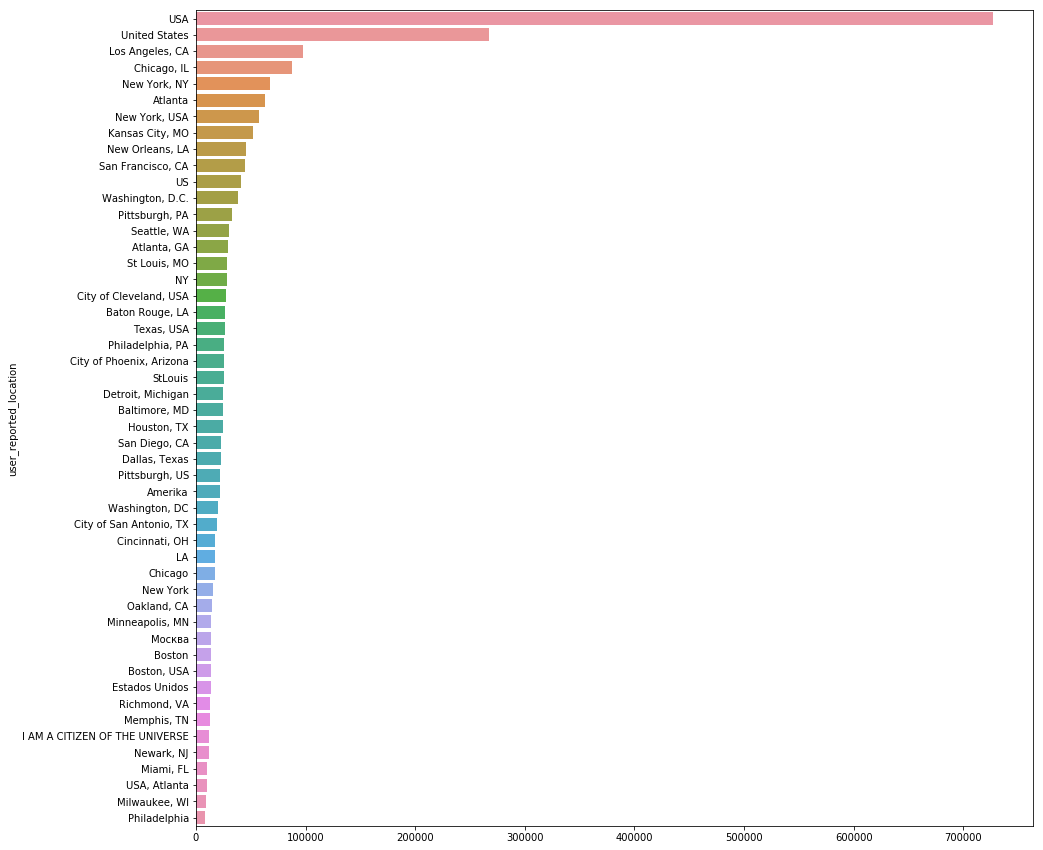

In [11]:
tweet_location = tweet_data.groupby("user_reported_location").count().sort_values("tweetid",ascending = False)
plt.figure(figsize=(15, 15))
sns.barplot(y= tweet_location.iloc[0:50,0].index, x=tweet_location.iloc[0:50,0].values)

Interesting, 12400 "CITIZENS OF THE UNIVERSE". I wonder whether they all know each other. Let's visualize it.
Many of them just state USA, which seems a bit ood. We can later check their behaviour by location. 

---

Let's look at most active users

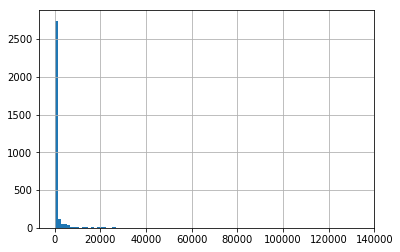

In [12]:
tweet_data['user_display_name'].value_counts().hist(bins = 100)

In [13]:
most_active = tweet_data['userid'].value_counts().iloc[0:1000]

Seems there is a "super active" user, let's find out more about it. Let's show some of his/her tweets.

In [14]:
most_active_user_tweets = tweet_data[tweet_data["userid"] == most_active.index[0]]["tweet_text"]
most_active_user_tweets.sample(5)

2629341    🚨🚨🚨🚨🚨 @NBC must take @AlecBaldwin out of @NBCSNL! #AbusiveAlec @ABFAlecBaldwin https://t.co/CDCq...
1893309    RT @ejabel2: Show sucks, sorry! Kat acts and looks like a goofy valley girl but wants to be take...
2069454    RT @perfectsliders: .@LouDobbs #BreakingNews Supreme Court has just upheld the Trump Administrat...
1705354    RT @WenMaMa2: .🚨Here is the REAL news 👉Just out ❗️ @realDonaldTrump @ThePatriot143 @The_Trump_Tr...
1208135    RT @BeachDreamin291: @ThomasWictor He should've recommended Hillary for prosecution. It was rumo...
Name: tweet_text, dtype: object

Let's look at the ratio RT vs content provider of most active users

In [15]:
users = most_active.index[0:100]
#tweet_data.userid.unique()[:100]
is_content_provider = []

for user in users:

    retweets = tweet_data[tweet_data["userid"] == user]["is_retweet"]
    is_content_provider.append(retweets.sum()/len(retweets))
    
is_content_provider = pd.DataFrame(is_content_provider, index=users, columns = ["ratio"])

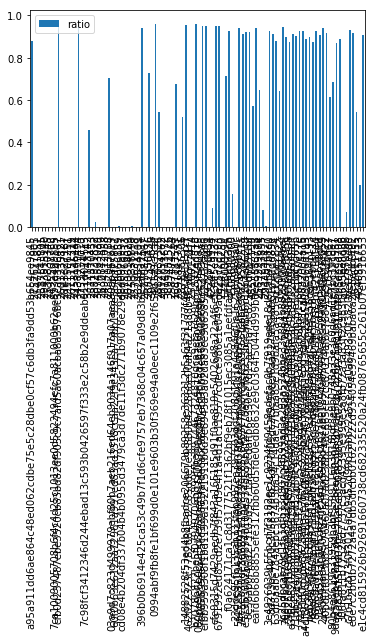

In [16]:
is_content_provider.plot.bar()

I would say there are clear content providers, the ones with lower rate and content spreaders, the ones with higher rate.

In [17]:
ret_users = tweet_data[tweet_data["userid"].isin(tweet_data.userid)]['retweet_userid'].value_counts().index
tweet_data[tweet_data["userid"].isin(ret_users)]['tweetid'].count()/len(tweet_data)

0.8263054516894375

OH .. what a surprise, they are retweeting one to each other 80% of the time.

---

Let's check when these accounts where created

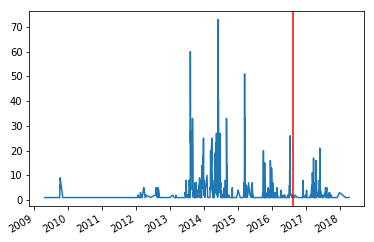

In [18]:
date_creation = user_data["account_creation_date"].value_counts().sort_index()
date_creation.index = pd.to_datetime(date_creation.index)
date_creation.plot()
plt.axvline(x=pd.to_datetime('08-11-2016'), color = 'red')

The account creation seem concentrated before the USA elections... but why are there some being created afterwards?

Let's check when there were more tweets.

In [19]:
tweet_data.tweet_time = pd.to_datetime(tweet_data.tweet_time)
tweet_data = tweet_data.set_index('tweet_time')

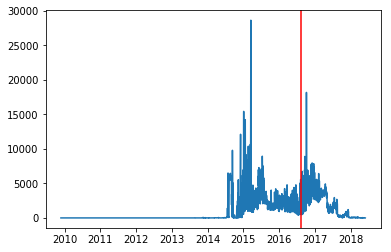

In [20]:
tweet_data["tweetid"].groupby(tweet_data.index.date).count().plot()
plt.axvline(x=pd.to_datetime('08-11-2016'), color = 'red')

Before USA elections seem to be high activity that climbs up again after elections.

In [21]:
tweet_data["tweetid"].groupby(tweet_data.index.date).count().argmax()

/Users/seb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


datetime.date(2015, 3, 18)

What happened this day ?

---

What about most used hashtags?

In [22]:
hashtags = tweet_data.hashtags.str.extractall(r'(\w+)')
hashtags = hashtags.reset_index("match").drop(columns = 'match')

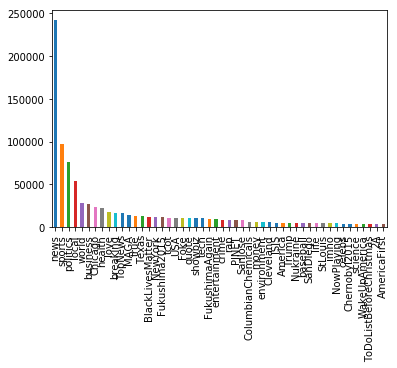

In [23]:
hashtags[0].value_counts()[:50].plot.bar()

In [24]:
hashtags2 = hashtags.reset_index().set_index(['tweet_time',0])

In [25]:
hashtags2.head()

Empty DataFrame
Columns: []
Index: [(2014-07-28 09:24:00, USA), (2017-03-25 07:54:00, BigSean), (2017-03-25 07:54:00, IDecidedTour), (2017-04-23 00:24:00, HenriettaLacks), (2017-01-19 21:54:00, Papoose)]

---

What are the words used by this tios

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    
    clean_pattern = [r'(@\w+=?:?)', #Mentions
                     r'(RT)', # Retweets
                     r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', # urls
                     r'(https)', # left over
                     r'(  +)', #Extra spaces
                     r'(\n)', # Break lines
                     r'[(]|[)]',# Parenthesis 
                     r'(#\w+)', # tags
                     r'(&w\+)'] 
    
    clean_pattern = '|'.join(clean_pattern)
    s = re.sub(clean_pattern,'',s)    
    return s


# Simple exploration
vectorizer = CountVectorizer(lowercase = False,
                             preprocessor = clean_twitter,
                            stop_words = 'english',
                            ngram_range= (1,2))

In [31]:
V = vectorizer.fit_transform(tweet_data[tweet_data["userid"].isin(most_active.index)]["tweet_text"])

In [28]:
words = vectorizer.get_feature_names()
counts = V.sum(axis=0)

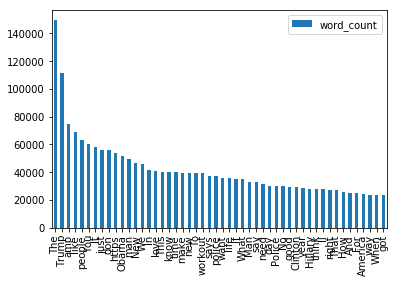

In [29]:
most_used_words = pd.DataFrame(counts.T, index = words, columns = ["word_count"])
most_used_words.sort_values(by ='word_count',ascending=False).head(50).plot.bar()

IDEAS :

- Check words used for most active users
- MOst active user tweets date

# Embedding tweets for clustering

### Steps:
- strip jibberish
- tokenize
- stem
- embed
- cluster
- look for pattern
- cluster with labels (to-do!)

In [53]:
from bs4 import BeautifulSoup
import re
import nltk

def clean_twitter_seb(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    
    # Jordi's regex kicks out all unwanted stuff
    clean_pattern = [r'(@\w+=?:?)', #Mentions
                     r'(RT)', # Retweets
                     r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', # urls
                     r'(https)', # left over
                     r'(  +)', #Extra spaces
                     r'(\n)', # Break lines
                     r'[(]|[)]',# Parenthesis 
                     r'(#\w+)', # tags
                     r'(&w\+)'] 
    
    clean_pattern = '|'.join(clean_pattern)
    s = re.sub(clean_pattern,'',s)    

    # Seb's pattern sort of does the same
    pattern = r"(?u)\b\w\w+\b"
    pattern = re.compile(pattern)
    
    # Together they work well! And return all expressions in s that match pattern
    return(pattern.findall(s))
    pass

## The raw data

In [37]:
tweet_data.tweet_text

tweet_time
2015-02-16 16:19:00    As sun and cloud give way to moon and shadow, the rhythm of the world makes itself apparent, say...
2014-07-28 23:02:00                                                                 Down in the comfort of strangers, I...
2014-07-28 09:24:00                                                                    Im laughing more than i should #USA
2014-08-08 00:43:00                                                                           No, I'm not saying I'm sorry
2014-08-17 10:46:00                                                                          Laugh it all off in your face
2014-12-27 08:54:00                                         It takes courage to make a fool of yourself. – Charlie Chaplin
2015-03-16 14:33:00                                                          I want to be normal and live with a boyfriend
2015-01-08 07:45:00    « Reverie is when ideas float in our mind without reflection or regard of the understanding. » J...
2015-

## Cleaning, stemming, tokenization

In [ ]:
# Use porter algorithm for stemming, seems to be commonly used
from nltk.stem.porter import *
stemmer = PorterStemmer()
# do all at once
tweets = [tokenize(stemmer.stem(clean_twitter_seb(i))) for i in tweet_data.tweet_text]

In [ ]:
# check the result

In [58]:
tweets

[['as',
  'sun',
  'and',
  'cloud',
  'give',
  'way',
  'to',
  'moon',
  'and',
  'shadow',
  'the',
  'rhythm',
  'of',
  'the',
  'world',
  'makes',
  'itself',
  'apparent',
  'saying',
  'have',
  'faith',
  'in',
  'yourself',
  'you',
  'are',
  'this'],
 ['down', 'in', 'the', 'comfort', 'of', 'strangers'],
 ['im', 'laughing', 'more', 'than', 'should'],
 ['no', 'not', 'saying', 'sorri'],
 ['laugh', 'it', 'all', 'off', 'in', 'your', 'fac'],
 ['it',
  'takes',
  'courage',
  'to',
  'make',
  'fool',
  'of',
  'yourself',
  'charlie',
  'chaplin'],
 ['want', 'to', 'be', 'normal', 'and', 'live', 'with', 'boyfriend'],
 ['reverie',
  'is',
  'when',
  'ideas',
  'float',
  'in',
  'our',
  'mind',
  'without',
  'reflection',
  'or',
  'regard',
  'of',
  'the',
  'understanding',
  'john',
  'lock'],
 ['rt',
  'saw',
  'it',
  'several',
  'days',
  'ago',
  'during',
  'trip',
  'and',
  'that',
  'amazing',
  'can',
  'you',
  'see',
  'the',
  'face',
  'who',
  'is',
  'it'],

## Train word vectors using Word2Vec

In [60]:
from gensim.models import Word2Vec

model = Word2Vec(tweets, size=100, window=10, min_count=1, workers=8)
model.train(tweets, total_examples=1, epochs=2)

(52603648, 62410980)

## Generate a word vector for each tweet

In [61]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) 
    a /= np.linalg.norm(a)
    return a

In [63]:
# use each model in turn to embed the individual reviews
w2v_matrix = np.array([embed_w2v(t, model) for t in tweets])

In [70]:
w2v_matrix.shape

(2997181, 100)

## Cluster based on the embedded vectors

In [67]:
from sklearn.mixture import GaussianMixture as gm

In [72]:
cluster = gm(2)
cluster.fit(X = w2v_matrix)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [76]:
result = cluster.predict(X = w2v_matrix)

In [84]:
result.shape

(2997181,)

## Check the reviews that have been clustered together

In [85]:
bool_result = np.array(result, dtype=bool)

In [86]:
tweet_data.tweet_text[bool_result].shape

(1861647,)

In [87]:
tweet_data.tweet_text[bool_result]

tweet_time
2017-03-25 07:54:00    RT @Real923LA: A few of our lucky listeners hanging out at the Palladium tonight, waiting for @B...
2017-01-19 21:54:00    RT @RappersIQ: #Papoose Ft. #RemyMa "Black Love" #Remix #PRO https://t.co/LBcdBBi1Q9 #TBT #Day #...
2017-01-29 17:37:00    RT @2DopeBoyz: Press play on @knxwledge's WT.PRT10.8 project; with flips of @Drake, @21Savage, @...
2017-04-21 20:01:00    RT @BlackNewsOutlet: Bobby Seale and Huey Newton, the founders of the Black Panther Party, 1966....
2016-10-06 17:34:00    RT @Herobright2: @UNHumanRights NIGERIA CRIES OUT: "AVENGERS HAVE FINISHED US" https://t.co/3GYr...
2017-04-12 03:40:00    RT @DJMistaXclusive: Cavs openly question their true nature as season comes to a close https://t...
2017-04-09 15:45:00             Mexico City metro now has a penis seat to combat sexual harassment https://t.co/mVOdLYiNys
2015-11-06 07:29:00    @CapLarryDart @Co_Passenger won't stricter gun control change the situation? Is it really necess...
2015-

In [89]:
tweet_data.tweet_text[~bool_result]

tweet_time
2015-02-16 16:19:00    As sun and cloud give way to moon and shadow, the rhythm of the world makes itself apparent, say...
2014-07-28 23:02:00                                                                 Down in the comfort of strangers, I...
2014-07-28 09:24:00                                                                    Im laughing more than i should #USA
2014-08-08 00:43:00                                                                           No, I'm not saying I'm sorry
2014-08-17 10:46:00                                                                          Laugh it all off in your face
2014-12-27 08:54:00                                         It takes courage to make a fool of yourself. – Charlie Chaplin
2015-03-16 14:33:00                                                          I want to be normal and live with a boyfriend
2015-01-08 07:45:00    « Reverie is when ideas float in our mind without reflection or regard of the understanding. » J...
2015-

## Predict the probabilities with which the reviews belong to this cluster

In [90]:
result_probs = cluster.predict_proba(X = w2v_matrix)

In [93]:
result_probs.shape

(2997181, 2)

In [96]:
tweet_data.tweet_text.shape

(2997181,)

In [99]:
tweet_probs = np.concatenate((result_probs, tweet_data.tweet_text[:,None]), axis = 1)

In [100]:
tweet_probs

array([[0.9999999999987779, 1.2251561674998508e-12,
        'As sun and cloud give way to moon and shadow, the rhythm of the world makes itself apparent, saying, have faith in yourself, you are this.'],
       [0.9998669460430663, 0.00013305395693571833,
        'Down in the comfort of strangers, I...'],
       [0.9999273684586646, 7.263154133453533e-05,
        'Im laughing more than i should #USA'],
       ...,
       [1.7807411603731805e-12, 0.9999999999982236,
        'Great souls endure in silence.'],
       [1.0, 5.636621474913677e-19,
        'Learn how to be happy with what you have while you pursue all that you want.'],
       [6.405552436285413e-68, 1.0,
        'Watch #COINTELPRO 101 (2010) online via DOCcupy']], dtype=object)

## Based on the Russian bot vocab, which words are similar?

In [91]:
display(model.wv.most_similar('trump'))
display(model.wv.most_similar('hillary'))
display(model.wv.most_similar('mexico'))
display(model.wv.most_similar('isis'))
display(model.wv.most_similar(positive=['trump'], negative=['hillary']))

[('trumps', 0.7028540372848511),
 ('obama', 0.7010419368743896),
 ('trum', 0.6913195848464966),
 ('hillary', 0.6393288373947144),
 ('lambro', 0.584241509437561),
 ('sanders', 0.5730369687080383),
 ('gop', 0.5681971311569214),
 ('establishment', 0.5672341585159302),
 ('rnc', 0.5631352066993713),
 ('potus', 0.5599875450134277)]

[('hrc', 0.8052111864089966),
 ('killary', 0.6954483985900879),
 ('clinton', 0.6544746160507202),
 ('trump', 0.6393288373947144),
 ('sanders', 0.6259757280349731),
 ('eberwein', 0.6246019601821899),
 ('hilary', 0.6192013025283813),
 ('dnc', 0.6180458068847656),
 ('she', 0.6140198707580566),
 ('wikileaks', 0.6115797758102417)]

[('glover', 0.4248843193054199),
 ('steve', 0.41156870126724243),
 ('trumps', 0.40952134132385254),
 ('pena', 0.4021785259246826),
 ('nieto', 0.3969365954399109),
 ('disputed', 0.3886382579803467),
 ('nidco', 0.38862231373786926),
 ('skydeck', 0.3804788589477539),
 ('pyongyang', 0.37971293926239014),
 ('stridently', 0.3770134150981903)]

## Let's also visualise this

In [117]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

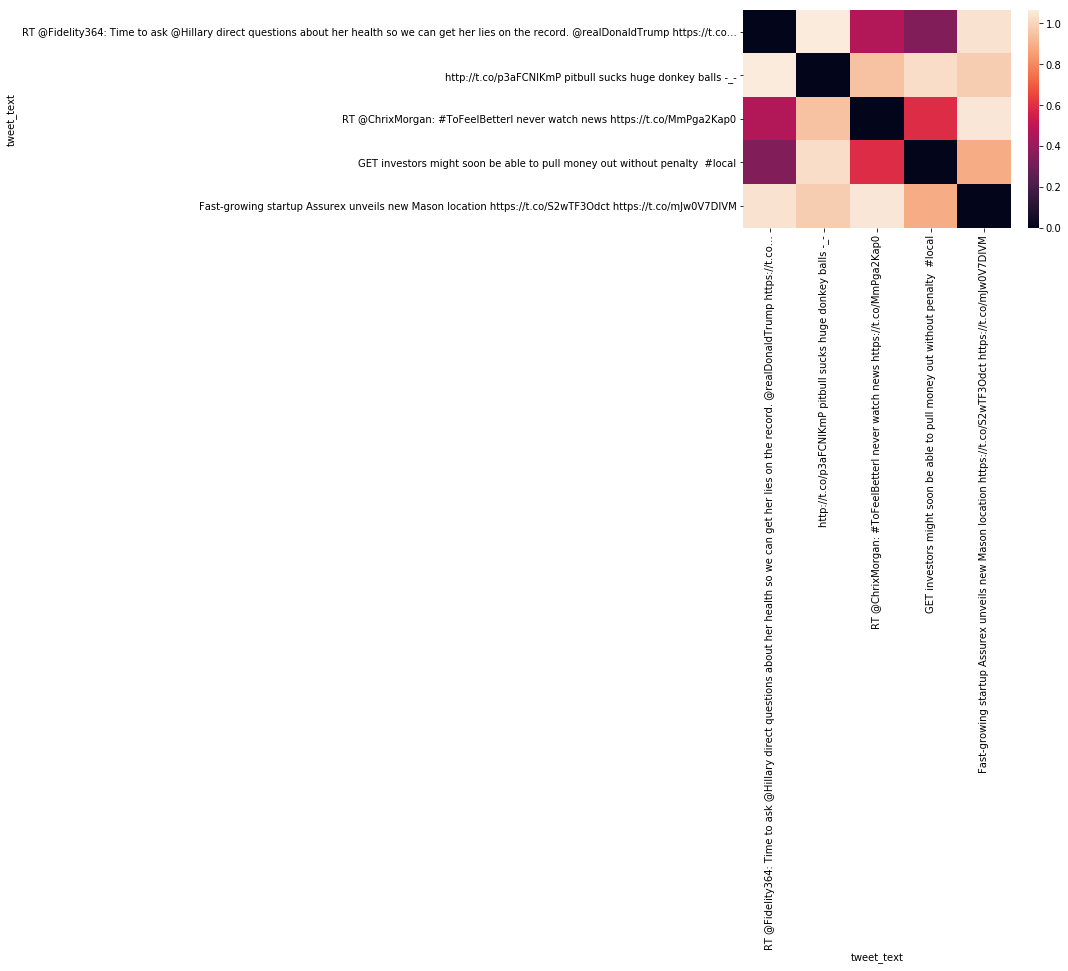

In [118]:
idx = np.random.randint(0, len(tweet_data.tweet_text), size=5)
visualize_dist(w2v_matrix, tweet_data.tweet_text, idx)